In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os

In [3]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

# Build Model: Density

Import feature set, import data

In [52]:
with gzip.open('./datasets/density_features.pkl.gz', 'rb') as fp:
    X_dens = pkl.load(fp)
with gzip.open('./datasets/density_data.pkl.gz', 'rb') as fd:
    densityData = pkl.load(fd)

In [33]:
density_model = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])
dens_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [34]:
%%time
density_model.fit(X_dens, y=densityData['density'])

Wall time: 369 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [35]:
print(np.shape(X_dens))
print(len(density_model.steps[1][1].feature_importances_))
print(len(dens_featurizer.feature_labels()))

(701, 152)
152
152


In [75]:
# Look at feature importances when trained on the whole data set
featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
# featureImp.to_csv(os.path.join(os.getcwd(),'results','defaultDensityModel_features.csv'))

In [66]:
# Look at feature importances when trained on the whole data set
featureImpUnsort = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance'])
featureImpUnsort.iloc[-7]

importance    0.000901
Name: Yang omega, dtype: float64

In [19]:
# make scorer for r2 metric
r2_scorer = make_scorer(r2_score)

# Generate learning curves, assess quality of model

In [40]:
train_sizes, train_scores, valid_scores = learning_curve(density_model, X_dens, densityData['density'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

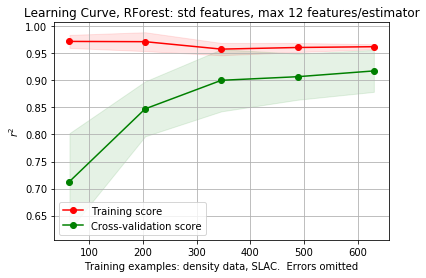

In [78]:
plt.figure()
plt.title('Learning Curve, RForest: std features, max 12 features/estimator')
plt.xlabel("Training examples: density data, SLAC.  Errors omitted")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.savefig(os.path.join(os.getcwd(), 'results', 'baseModel_densityPruned.png'))

In [60]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
densityData['density_predict'] = np.nan
for train_index, test_index in kf.split(densityData['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_dens[train_index,:], densityData['density'][train_index])
    
    y_densPredict = density_model.predict(X_dens[test_index,:])
    densityData['density_predict'][test_index] = y_densPredict
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


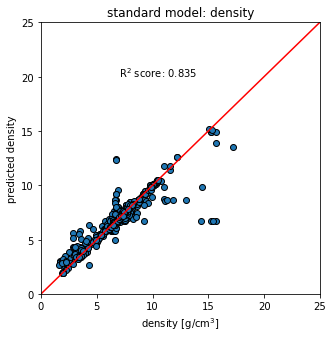

In [98]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density')

r2Std = r2_score(densityData['density'], densityData['density_predict'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2Std))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('standard model: density')

plt.savefig(os.path.join(os.getcwd(),'results','densityScatter.png'))

Compare to Vegard's law, rule of mixtures

In [44]:
elemProp = pd.read_excel('datasets/ElementalDensityIonizationTable.xlsx')
elemDensity = elemProp[['symbol', 'density [g/cm3]']]

def vegardsDensity(comp):
    '''
    input: Composition object
    '''
        
    density=0
    elemSet = set(comp.elements)
    subscriptCnt = 0
    
    for elem in elemSet:
        subscriptCnt += comp[elem]
        try: 
            densityPart = comp[elem]*elemDensity[ elemDensity['symbol'] == str(elem)]['density [g/cm3]'].item()
        except:
            print('element {} not found?'.format(elem))
            return 'error'
            
        density += densityPart
        # print('element {} added density of {}: {}'.format(elem, densityPart, density))
                
    # print(subscriptCnt)
    return density / subscriptCnt

In [45]:
comp = Composition('Ag10Zn30')
comp2 = Composition('Ca3Al4')

In [46]:
vegardsDensity(comp2)

2.2071428571428573

In [68]:
#densityData['density_vegards'] = pd.Series([vegardsDensity(comp) for comp in densityData['comp']])
r2Vegards = r2_score(densityData['density'],densityData['density_vegards'])
r2RF = r2_score(densityData['density'], densityData['density_predict'])
print('Vegards: {}, Random Forest Regressor: {}'.format(r2Vegards, r2RF))

Vegards: 0.8614466511737545, Random Forest Regressor: 0.8354906118737868


In [49]:
#densityData[densityData['density_vegards']=='error']

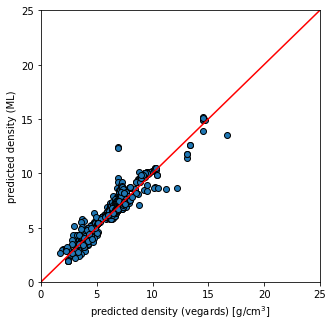

In [63]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density_vegards'], densityData['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('predicted density (vegards) [g/cm$^3$]')
plt.ylabel('predicted density (ML)')

plt.xlim([0,25])
plt.ylim([0,25])

plt.savefig(os.path.join(os.getcwd(),'results','densityVegards.png'))

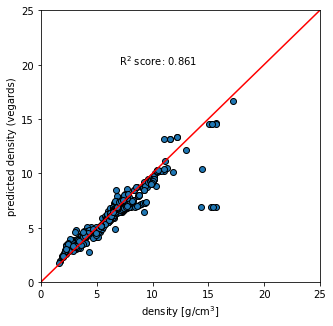

In [97]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (vegards)')

r2V = r2_score(densityData['density'], densityData['density_vegards'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

plt.savefig(os.path.join(os.getcwd(),'results','densityVegardsVsTruth.png'))

# Alternate Feature Set, only mean from ElementProperty feature set

In [80]:
densModel_meanOnly = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])
elemPropFeatures = ["Number", "MendeleevNumber", "AtomicWeight", "MeltingT",
                        "Column", "Row", "CovalentRadius",
                        "Electronegativity", "NsValence", "NpValence",
                        "NdValence", "NfValence", "NValence",
                        "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled",
                        "NUnfilled", "GSvolume_pa",
                        "GSbandgap", "GSmagmom", "SpaceGroupNumber"]

densMean_featurizer = MultipleFeaturizer([cf.Stoichiometry(), 
                          cf.ElementProperty(data_source='magpie', features = ["Number",     
                                                    "MendeleevNumber", "AtomicWeight", "MeltingT",
                                                    "Column", "Row", "CovalentRadius",
                                                    "Electronegativity", "NsValence", "NpValence",
                                                    "NdValence", "NfValence", "NValence",
                                                    "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled",
                                                    "NUnfilled", "GSvolume_pa",
                                                    "GSbandgap", "GSmagmom", "SpaceGroupNumber"],
                                                    stats=['mean']),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [82]:
%%time
X_meanDens = densMean_featurizer.featurize_many(densityData['comp'], ignore_errors=True)
X_meanDens = np.array(X_meanDens)
X_meanDens.astype(float)
print('Computed {} features'.format(X_meanDens.shape[1]))

Computed 42 features
Wall time: 18min 23s


In [84]:
%%time 
# Fit the model
densModel_meanOnly.fit(X_meanDens, densityData['density'])

Wall time: 463 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [85]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
densityData['density_predict_meanOnly'] = np.nan
for train_index, test_index in kf.split(densityData['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_meanDens[train_index,:], densityData['density'][train_index])
    
    y_densPredict = density_model.predict(X_meanDens[test_index,:])
    densityData['density_predict_meanOnly'][test_index] = y_densPredict
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


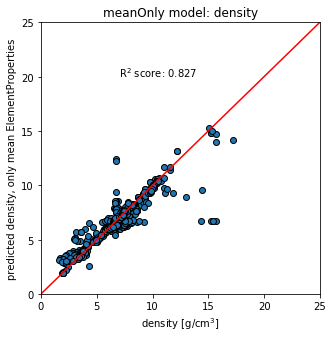

In [99]:
# plot Comparison, report r2
r2meanOnly = r2_score(densityData['density'], densityData['density_predict_meanOnly'])

plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_predict_meanOnly'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density, only mean ElementProperties')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2meanOnly))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('meanOnly model: density')

plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_meanOnly.png'))

In [92]:
train_sizesMean, train_scoresMean, valid_scoresMean = learning_curve(densModel_meanOnly, X_meanDens, densityData['density'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

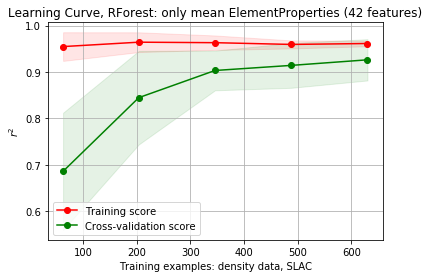

In [94]:
plt.figure()
plt.title('Learning Curve, RForest: only mean ElementProperties (42 features)')
plt.xlabel("Training examples: density data, SLAC")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scoresMean, axis=1)
train_scores_std = np.std(train_scoresMean, axis=1)
test_scores_mean = np.mean(valid_scoresMean, axis=1)
test_scores_std = np.std(valid_scoresMean, axis=1)
plt.grid()

plt.fill_between(train_sizesMean, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizesMean, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizesMean, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizesMean, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.savefig(os.path.join(os.getcwd(), 'results', 'baseModel_densityMeanOnly.png'))

# Investigating poorly performing predictions

In [113]:
largeErrorDensity = densityData[ [ abs((x-y)/x) > 0.5 for x,y in zip(densityData['density'], densityData['density_predict']) ]]

In [114]:
largeErrorDensity

,comp,density,density_vegards,density_predict,density_predict_meanOnly
1,"(Al, Fe, B)",3.539,3.66200,5.817383,4.844840
4,"(Hf, Al, Ni)",2.835,3.85050,5.581040,3.982367
5,"(Nb, Al, Ni)",3.449,3.61350,5.549445,4.016457
24,"(Al, V, Fe)",2.884,2.93980,5.143712,3.805915
56,"(Y, Mg, Zn, Cu)",2.47,2.80927,3.906464,3.730377
67,"(Ca, Al)",1.738,1.93640,3.080266,3.283033
68,"(Ca, Al, Ag)",2.197,2.79000,3.469263,3.500853
69,"(Ca, Mg, Al)",1.736,1.91400,2.946232,3.091332
70,"(Ca, Al, Zn)",2,2.45300,3.018026,3.245160
71,"(Ca, Mg, Al, Cu)",1.871,2.26725,2.996972,3.264013


In [116]:
for comp in largeErrorDensity['comp']:
    print(comp)

Al3 Fe1 B1
Hf1 Al17 Ni2
Nb1 Al17 Ni2
Al47 V2 Fe1
Y4.7 Mg81 Zn5 Cu9.3
Ca66.4 Al33.6
Ca6 Al3 Ag1
Ca6 Mg1 Al3
Ca6 Al3 Zn1
Ca56.5 Mg10 Al28.5 Cu5
Ca56.5 Mg10 Al28.5 Ag5
Ca14 Mg3 Al3
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
